In [3]:
import matplotlib.pyplot as plt

from glyphs_generator.build import initialize_generator_parameters
from glyphs_generator.data import Point, Stroke
from glyphs_generator.generate import GlyphGenerator
from glyphs_generator.rasterize import rasterize_all

anchor_points = [
    Point(-1, -1),
    Point(-1, 1),
    Point(1, -1),
    Point(1, 1),
    Point(0, 0),
    Point(-1, 0),
    Point(1, 0),
    Point(0, 1),
    Point(0, -1),
]
parameters = initialize_generator_parameters(anchor_points)
generator = GlyphGenerator(parameters)

(-0.5, 51.5, 12.5, -0.5)

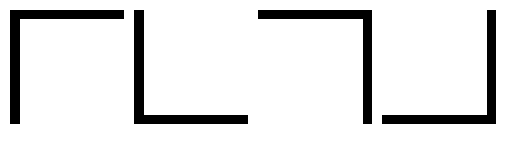

In [3]:
from glyphs_generator.data import Stroke, Glyph

a = Stroke(-1, -1, -1, 1)
b = Stroke(-1, -1, 1, -1)
c = Stroke(-1, 0, 1, 0)
d = Stroke(-1, -1, 1, 1)
e = Stroke(-1, 1, 1, 1)
f = Stroke(0, -1, 0, 1)
g = Stroke(1, -1, -1, 1)
h = Stroke(1, -1, 1, 1)

glyphs = [
    Glyph(strokes=[a, b]),
    Glyph(strokes=[a, e]),
    Glyph(strokes=[b, h]),
    Glyph(strokes=[e, h]),
]
tensor = rasterize_all(glyphs=glyphs, nb_glyphs_per_row=len(glyphs), glyph_size=12)
plt.imshow(255 - 255 * tensor, cmap="gray")
plt.axis("off")
# plt.savefig(f"glyph-equivalence-class.svg", transparent=True, bbox_inches="tight");

(-0.5, 104.5, 125.5, -0.5)

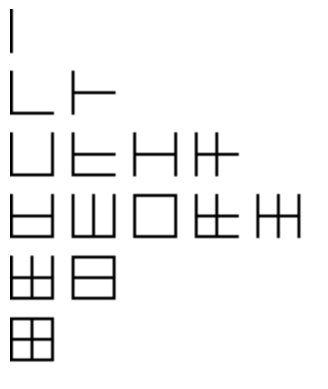

In [6]:
strokes = [
    Stroke(-1, -1, -1, 1),
    Stroke(1, -1, 1, 1),
    Stroke(-1, 1, 1, 1),
    Stroke(-1, 0, 1, 0),
    Stroke(0, 1, 0, -1),
    Stroke(1, -1, -1, -1),
]
seed = strokes[0]
glyphs = generator.generate(strokes, seed)
tensor = rasterize_all(glyphs, glyph_size=15, margin=6, sort=True) 
plt.imshow(255 - 255 * tensor, cmap="gray")
plt.axis("off")
# plt.savefig(f"10-glyph.svg", transparent=True, bbox_inches="tight");

(-0.5, 314.5, 167.5, -0.5)

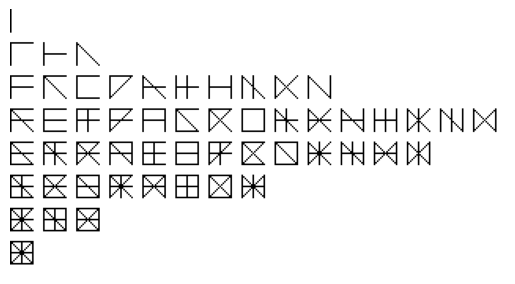

In [7]:
strokes = [
    Stroke(-1, -1, -1, 1),
    Stroke(-1, -1, 1, -1),
    Stroke(-1, 0, 1, 0),
    Stroke(-1, -1, 1, 1),
    Stroke(-1, 1, 1, 1),
    Stroke(0, -1, 0, 1),
    Stroke(1, -1, -1, 1),
    Stroke(1, -1, 1, 1),
]
seed = strokes[0]
glyphs = generator.generate(strokes, seed)
tensor = rasterize_all(glyphs, glyph_size=15, margin=6, sort=True) 
plt.imshow(255 - 255 * tensor, cmap="gray")
plt.axis("off")
# plt.savefig(f"10-glyph.svg", transparent=True, bbox_inches="tight");

In [80]:
import pandas as pd
from pydantic import BaseModel


class Coordinates(BaseModel):
    x0: float
    y0: float
    x1: float
    y1: float

class Model(BaseModel):
    strokes: list[Coordinates]

matrix = Model.model_validate_json('{"strokes":[{"x0":-1,"y0":-1,"x1":1,"y1":1},{"x0":1,"y0":1,"x1":-1,"y1":1},{"x0":-1,"y0":1,"x1":1,"y1":-1},{"x0":1,"y0":-1,"x1":-1,"y1":-1},{"x0":-1,"y0":-1,"x1":-1,"y1":1},{"x0":1,"y0":-1,"x1":1,"y1":1},{"x0":1,"y0":0,"x1":-1,"y1":0},{"x0":0,"y0":-1,"x1":0,"y1":1},{"x0":0,"y0":-1,"x1":-1,"y1":0},{"x0":-1,"y0":0,"x1":0,"y1":1},{"x0":0,"y0":1,"x1":1,"y1":0},{"x0":1,"y0":0,"x1":0,"y1":-1}]}')
strokes = [Stroke(s.x0, s.y0, s.x1, s.y1) for s in matrix.strokes]
glyphs = generator.generate(strokes, strokes[0])

def order_glyphs(glyphs):
    ordered = {}
    for glyph in glyphs:
        k = len(glyph.strokes)
        if k not in ordered:
            ordered[k] = []
        ordered[k].append(glyph)
    return ordered


records = []
o = order_glyphs(glyphs)
for k, k_glyphs in o.items():
    for k_glyph in k_glyphs:
        sub_glyphs = generator.generate(k_glyph.strokes, k_glyph.strokes[0])
        argmax = 0
        last_max = 0
        for i, i_glyphs in order_glyphs(sub_glyphs).items():
            if len(i_glyphs) > last_max:
                last_max = len(i_glyphs)
                argmax = i
        records.append({"n": k, "most_freedom_k_glyph": argmax})

df = pd.DataFrame.from_records(records)

(0.0, 1.0)

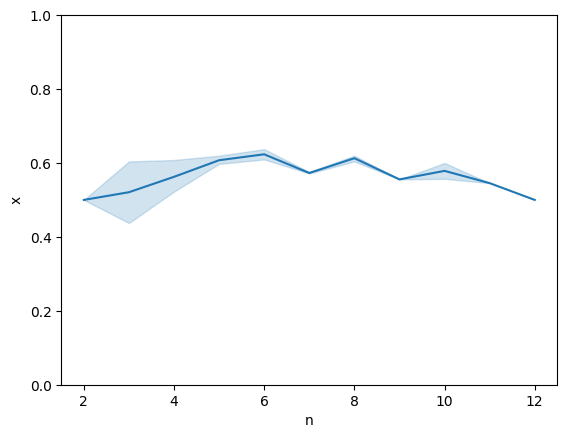

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

df["x"] = df.apply(lambda x: float(x["most_freedom_k_glyph"]) / float(x["n"]), axis=1)
df = df[df.n > 1]
sns.lineplot(df, x="n", y="x")
plt.ylim([0, 1])

<Axes: xlabel='n', ylabel='most_freedom_k_glyph'>

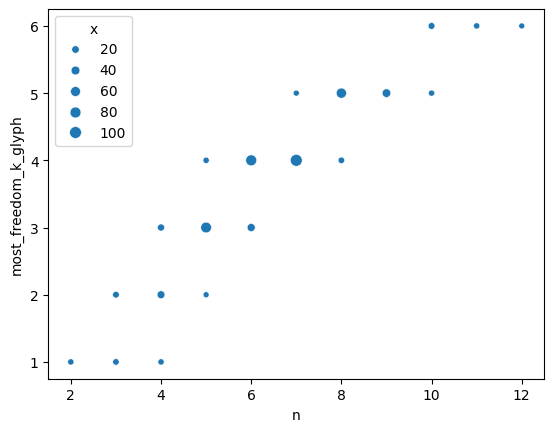

In [106]:
df_count = df.pivot_table(index=["n", "most_freedom_k_glyph"], aggfunc="count").reset_index()
sns.scatterplot(df_count, x='n', y='most_freedom_k_glyph', size="x")
#sns.scatterplot(df, x='n', y='x', size="count")